In [1]:
%load_ext autoreload
%autoreload 2

# Visualise ruggedness verified for trained models

In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.data.data_format_tools.common import write_json
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.utils.evolution import calculate_ruggedness_core
from evoscaper.utils.math import arrayise, make_flat_triangle
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.visualise import make_sort_hue
from evoscaper.utils.visualise import create_network_inset, make_nx_weights

import matplotlib.gridspec
from scipy.cluster.hierarchy import fcluster

import os
import json
import sys
import numpy as np
import jax

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')


sns.set_style('whitegrid')

# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


np.random.seed(0)
PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 02_cvae_verify.ipynb --output=02_cvae_verify_2.ipynb --ExecutePreprocessor.timeout=-1

[CpuDevice(id=0)]

# Settings + load params

In [3]:
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_03_25__12_53_19')
config_rugg = load_json_as_dict(os.path.join(dir_src_rugg, 'config.json'))
fn_df_hpos_loaded = config_rugg['fn_df_hpos_loaded'].replace('notebooks/', '')
hpos = pd.Series(load_json_as_dict(fn_df_hpos_loaded))
dir_src_nn = os.path.dirname(fn_df_hpos_loaded)
fn_saves = os.path.join(dir_src_nn, [i for i in os.listdir(dir_src_nn) if i.startswith('saves')][0])

config = {'fn_saves': fn_saves,
       'dir_src_rugg': dir_src_rugg}
top_write_dir = os.path.join('data', '16_visualise_rugged_verify', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)
with open(os.path.join(top_write_dir, 'config.json'), 'w') as f:
    json.dump(config, f)
print('top_write_dir:', top_write_dir)
    

top_write_dir: data/16_visualise_rugged_verify/2025_04_22__14_43_06


In [4]:
saves_loaded = load_json_as_dict(fn_saves)
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
params = arrayise(params)

config_bio = load_json_as_dict(config_dataset.filenames_verify_config)
if 'base_configs_ensemble' in config_bio:
    val_config = config_bio['base_configs_ensemble']['generate_species_templates']
    val_config.update(config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal'])
else:
    val_config = config_bio
    
    

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Load analytics - if necessary, stitch batches together from ruggedness directory

In [5]:
fn_analytics = os.path.join(dir_src_rugg, 'analytics.json')

if os.path.exists(fn_analytics):
    analytics_rugg = load_json_as_dict(fn_analytics)
    for k, v in analytics_rugg.items():
        analytics_rugg[k] = np.array(v)
    if 'adaptation' not in analytics_rugg.keys():
        analytics_rugg['adaptation'] = calculate_adaptation(analytics_rugg['sensitivity'], analytics_rugg['precision'], alpha=2)
else:
    # Stitch together ruggedness from batches
    analytics_rugg = {}
    # for fn_analytic in ['analytics.json', 'analytics2.json']:
    for dir_batch in [f'batch_{i}' for i in np.arange(12)]:
        if (not os.path.exists(os.path.join(dir_src_rugg, dir_batch))) or (
            len(os.listdir(os.path.join(dir_src_rugg, dir_batch))) == 0):
            continue
        analytics_batch = load_json_as_dict(os.path.join(dir_src_rugg, dir_batch, 'analytics.json'))
        # analytics_batch = load_json_as_dict(os.path.join(dir_src_rugg, fn_analytic))
        for k, v in analytics_batch.items():
            if k not in analytics_rugg:
                analytics_rugg[k] = np.array(v)
            else:
                analytics_rugg[k] = np.concatenate([analytics_rugg[k], np.array(v)], axis=0)
                
    if 'adaptation' not in analytics_rugg.keys():
        analytics_rugg['adaptation'] = calculate_adaptation(analytics_rugg['sensitivity'], analytics_rugg['precision'], alpha=2)

    write_json(analytics_rugg, fn_analytics)

In [6]:
analytics_rugg.pop('RMSE', None)
'1'

'1'

### Load fake circuits

In [7]:
# from evoscaper.utils.simulation import load_config_bio, sim, prep_cfg, setup_model_brn, compute_analytics
# from evoscaper.scripts.cvae_scan import generate_all_fake_circuits

# df_hpos = pd.DataFrame(hpos).T
# df_hpos['eval_n_to_sample'] = config_rugg['eval_n_to_sample']
# df_hpos['eval_cond_min'] = config_rugg['eval_cond_min']
# df_hpos['eval_cond_max'] = config_rugg['eval_cond_max']
# df_hpos['eval_n_categories'] = config_rugg['eval_n_categories']

# datasets = {v: pd.read_json(
#     v) for v in df_hpos['filenames_train_table'].unique() if os.path.exists(v)}
# input_species = datasets[list(datasets.keys())[
#     0]]['sample_name'].dropna().unique()
# fn_config_bio = df_hpos['filenames_verify_config'].dropna().unique()[0]

# config_bio = load_config_bio(
#     fn_config_bio, input_species, '../' + config_rugg.get('fn_simulation_settings'))

# model_brn, qreactions, postprocs, ordered_species = setup_model_brn(
#     config_bio, input_species)

# # df_hpos['output_species'] = df_hpos['output_species'].apply(lambda x: [x])
# all_fake_circuits, all_forward_rates, all_reverse_rates, all_sampled_cond = generate_all_fake_circuits(
#     df_hpos, datasets, input_species, postprocs)

all_fake_circuits = np.load(os.path.join(dir_src_rugg, 'all_fake_circuits.npy'))
all_sampled_cond = np.load(os.path.join(dir_src_rugg, '0', 'all_sampled_cond.npy'))

In [8]:
len(analytics_rugg['sensitivity']), all_fake_circuits.shape

(700000, (100000, 3, 3))

# Calculate ruggedness

In [9]:
n_samples = all_fake_circuits.shape[0]
n_interactions = make_flat_triangle(all_fake_circuits[0]).shape[-1]
n_perturbs = n_interactions + config_rugg['resimulate_analytics']
eps = config_rugg['eps_perc'] * np.abs(all_fake_circuits).max()
idx_output = -1

ruggedness = {}
# for analytic in config_dataset.objective_col:
for analytic in analytics_rugg.keys():
    ruggedness[analytic] = calculate_ruggedness_core(analytics_rugg, None, analytic,
                                                     config_rugg['resimulate_analytics'], n_samples, n_perturbs, eps)

In [10]:
if config_rugg['resimulate_analytics']:
    analytics_og = {k: np.array(v).reshape(n_samples, n_perturbs, -1)[:, -1, :] for k, v in analytics_rugg.items()}
else: 
    analytics_og = {}

In [11]:
k_rugg = 'Log ruggedness (adaptation)'

ruggedness[k_rugg] = np.log10(ruggedness['Log sensitivity'])

/tmp/ipykernel_2990223/3644252730.py:3: RuntimeWarning: divide by zero encountered in log10
  ruggedness[k_rugg] = np.log10(ruggedness['Log sensitivity'])


/tmp/ipykernel_2990223/2994278626.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x=sampled_rugg.flatten(), y=rugg_sens[..., idx_output], palette='viridis')


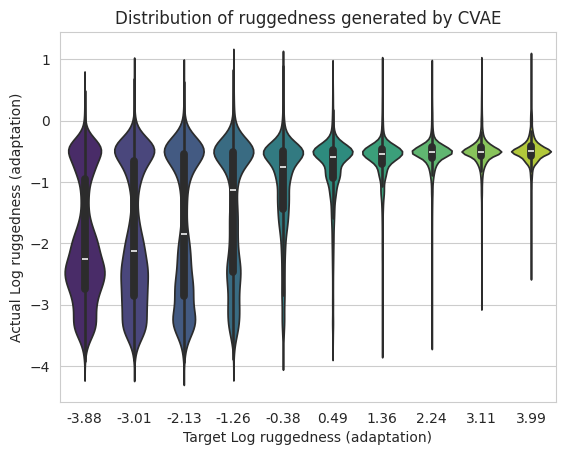

In [12]:
sampled_rugg = all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)]
rugg_sens = ruggedness[k_rugg]
sampled_rugg = y_datanormaliser.create_chain_preprocessor_inverse(
    y_methods_preprocessing)(sampled_rugg, col=k_rugg)
ax = sns.violinplot(x=sampled_rugg.flatten(), y=rugg_sens[..., idx_output], palette='viridis')
# ax = sns.barplot(x=sampled_rugg.flatten().round(1), y=rugg_sens[..., idx_output],
#                  hue=all_sampled_cond[..., config_dataset.objective_col.index(col_hue)].flatten())  # , alpha=0.5)
# hue=analytics_og['Log sensitivity'][..., idx_output], alpha=0.5)
# ax.get_legend().set_title('Target ' + col_hue)
plt.xlabel(f'Target {k_rugg}')
plt.xticks(ax.get_xticks(), [f'{i:.2f}' for i in sorted(np.unique(sampled_rugg.flatten()).round(2))])
plt.ylabel(f'Actual {k_rugg}')
plt.title('Distribution of ruggedness generated by CVAE')
plt.savefig(os.path.join(top_write_dir, 'ruggedness_violin.png'), dpi=300, bbox_inches='tight', transparent=True)



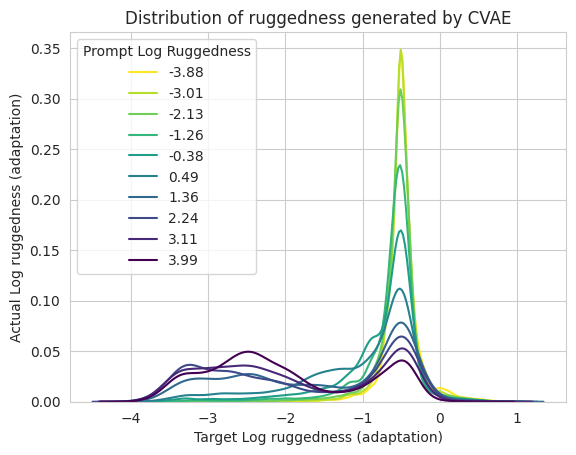

In [13]:
ax = sns.kdeplot(x=rugg_sens[..., idx_output], hue=sampled_rugg.flatten(), palette='viridis')
# ax = sns.barplot(x=sampled_rugg.flatten().round(1), y=rugg_sens[..., idx_output],
#                  hue=all_sampled_cond[..., config_dataset.objective_col.index(col_hue)].flatten())  # , alpha=0.5)
# hue=analytics_og['Log sensitivity'][..., idx_output], alpha=0.5)
# ax.get_legend().set_title('Target ' + col_hue)
plt.xlabel(f'Target {k_rugg}')
plt.ylabel(f'Actual {k_rugg}')
plt.title('Distribution of ruggedness generated by CVAE')
leg_text = [f'{ii:.2f}' for ii in np.unique(sampled_rugg.flatten())]
plt.legend(leg_text, title='Prompt Log Ruggedness')
plt.savefig(os.path.join(top_write_dir, 'ruggedness_kde.png'), dpi=300, bbox_inches='tight', transparent=True)


/tmp/ipykernel_2990223/1110343911.py:52: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1, i].set_ylim(0, count_max)


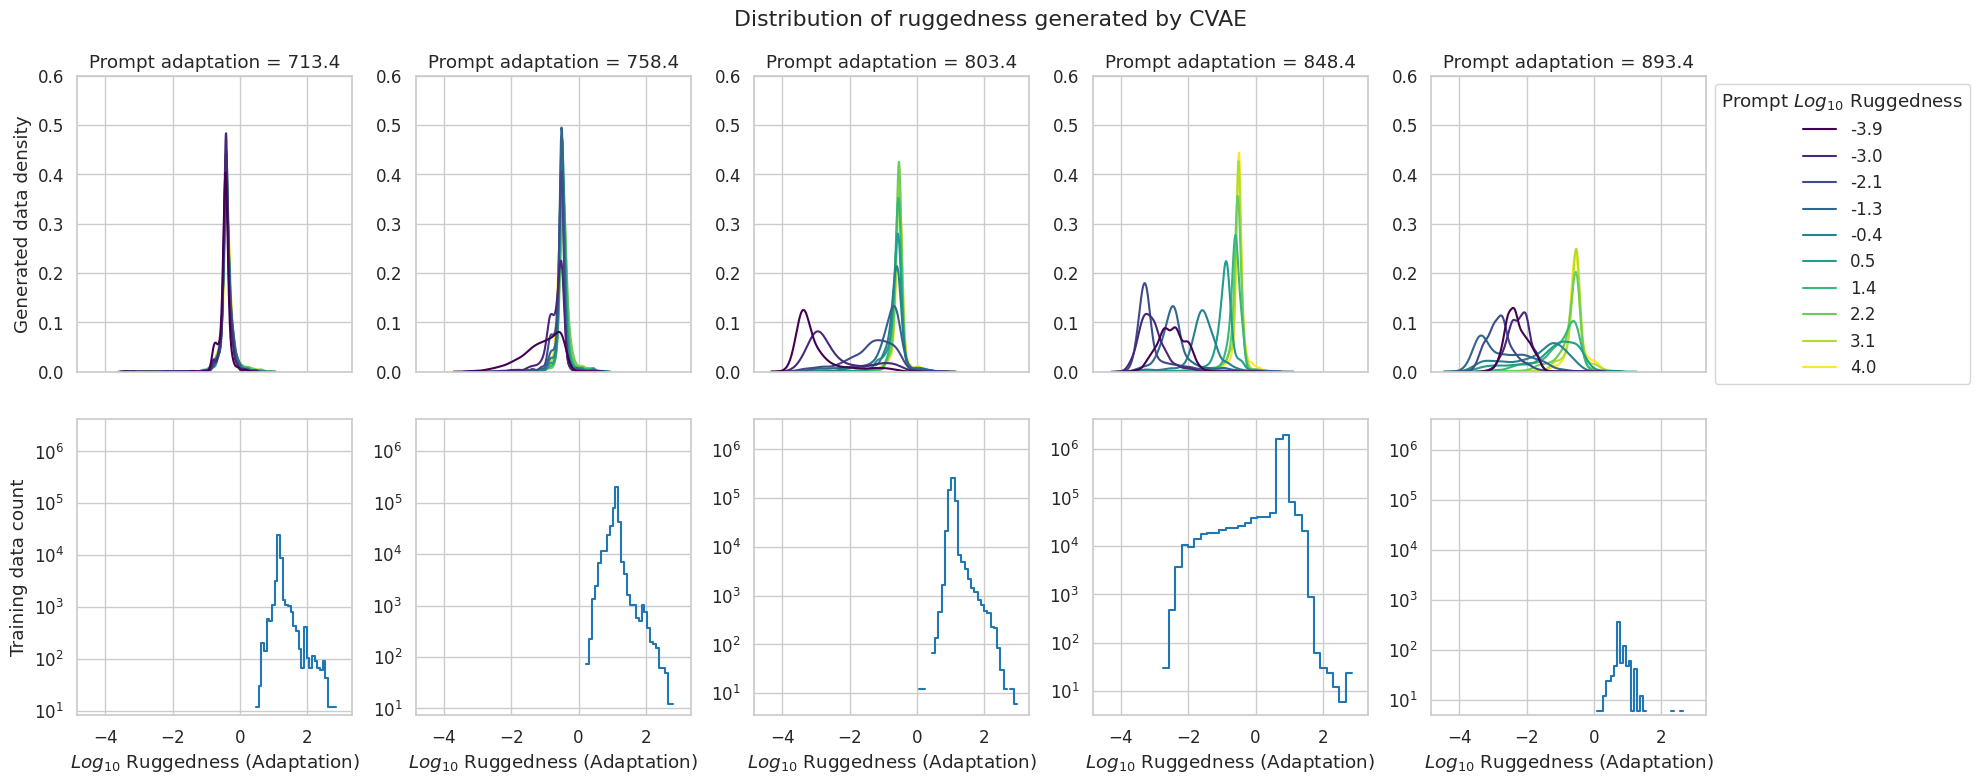

In [14]:
sns.set_context('notebook', font_scale=1.1)

if len(config_dataset.objective_col) == 2:
    k_other_idx = int(not(config_dataset.objective_col.index(k_rugg)))
    k_other = config_dataset.objective_col[k_other_idx]
    sampled_rev = y_datanormaliser.create_chain_preprocessor_inverse(
        y_methods_preprocessing)(all_sampled_cond[..., k_other_idx], col=k_other)
    uniq_sampled_other = np.unique(sampled_rev)
    uniq_sampled_other_half = uniq_sampled_other[::2]
    nrows = 2
    # ncols = int(np.ceil(len(uniq_sampled_other_half) / nrows))
    ncols = len(uniq_sampled_other_half)
    leg_text = [f'{ii:.2f}' for ii in np.unique(sampled_rugg.flatten())]
    fig, axs = plt.subplots(nrows, ncols, figsize=(
        4*ncols, 4*nrows), sharex=True) #, sharey=True)
    for i, v0 in enumerate(uniq_sampled_other_half):
        idxs_sampled0 = np.where(sampled_rev.flatten() == v0)[0]
        g = sns.kdeplot(x=rugg_sens[idxs_sampled0, idx_output],
                    hue=sampled_rugg.flatten()[idxs_sampled0].round(1), palette='viridis', ax=axs.flat[i])
        axs.flat[i].set_xlabel(f'{k_rugg}')
        axs.flat[i].set_title(
            f'Prompt {k_other} = {v0:.1f}')
        if i == (len(uniq_sampled_other_half) - 1):
            legend = g.legend_
            if legend:
                for text in legend.get_texts():
                    text.set_text(f"{float(text.get_text()):.1f}")
            sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title=r'Prompt $Log_{10}$ Ruggedness')
        else:
            axs.flat[i].get_legend().remove()
        axs[0, i].set_ylim(0, 0.6)
        axs[0, i].set_ylabel('')
    axs[0, 0].set_ylabel('Generated data density')
    plt.suptitle('Distribution of ruggedness generated by CVAE')
    
    filt_samp = data['sample_name'] == 'RNA_2'
    binned_data_samples_other = np.array(list(map(lambda x: uniq_sampled_other_half[x], np.argmin(np.abs(data[filt_samp][k_other].values[None, :] - uniq_sampled_other_half[:, None]), axis=0))))
    binned_data_samples_rugg = np.array(list(map(lambda x: np.unique(sampled_rugg.flatten())[x], np.argmin(np.abs(data[filt_samp][k_rugg].values[None, :] - np.unique(sampled_rugg.flatten())[:, None]), axis=0))))
    df_xbinned = pd.DataFrame()
    df_xbinned[k_other] = binned_data_samples_other
    df_xbinned[k_rugg] = data[filt_samp][k_rugg].values
    df_xbinned[x_cols] = data[filt_samp][x_cols].values
    d = pd.melt(df_xbinned, id_vars=[k_other, k_rugg], value_vars=x_cols, value_name='Input x', var_name='X type')
    count_max = 1
    for i, v0 in enumerate(uniq_sampled_other_half):
        sns.histplot(d[d[k_other] == v0], x=k_rugg, bins=30, ax=axs[1, i], log_scale=[False, True], element='step', fill=False)
        count_max = np.max([count_max, d[d[k_other] == v0].shape[0]])
        axs[1, i].set_ylabel('')
        axs[1, i].set_xlabel(r'$Log_{10}$ Ruggedness (Adaptation)')
    axs[1, 0].set_ylabel('Training data count')
    for i in range(ncols):
        axs[1, i].set_ylim(0, count_max)
        
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, 'ruggedness_by_prompt.png'), dpi=300, bbox_inches='tight', transparent=True)
    

/tmp/ipykernel_2990223/4019032967.py:6: RuntimeWarning: divide by zero encountered in log10
  ruggedness['adaptation'][..., idx_output] == 0, np.nan, np.log10(ruggedness['adaptation'][..., idx_output]))


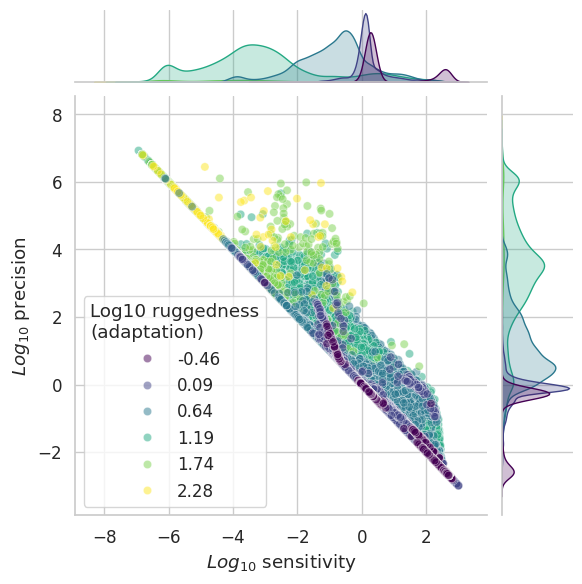

In [15]:
df_rugg = pd.DataFrame()
df_rugg['Log sensitivity'] = analytics_og['Log sensitivity'][..., idx_output]
df_rugg['Log precision'] = analytics_og['Log precision'][..., idx_output]
df_rugg['Adaptation'] = analytics_og['adaptation'][..., idx_output]
df_rugg['Log ruggedness (adaptation)'] = np.where(
    ruggedness['adaptation'][..., idx_output] == 0, np.nan, np.log10(ruggedness['adaptation'][..., idx_output]))
df_rugg['Log ruggedness (adaptation) bin'] = pd.cut(
    df_rugg['Log ruggedness (adaptation)'], bins=10)
df_rugg['Log ruggedness (adaptation) bin'] = df_rugg['Log ruggedness (adaptation) bin'].apply(
    lambda x: x.mid).astype(float).round(2)

idxs_show = make_sort_hue(df_rugg[df_rugg['Log ruggedness (adaptation) bin'] > -1]['Log ruggedness (adaptation) bin'].round(2), sort=True, sort_random=False, sort_flip_prop=4)

sns.jointplot(df_rugg[df_rugg['Log ruggedness (adaptation) bin'] > -1].iloc[idxs_show], 
              x='Log sensitivity', y='Log precision',
              hue='Log ruggedness (adaptation) bin', 
              alpha=0.5, palette='viridis')
plt.xlabel(r'$Log_{10}$ sensitivity')
plt.ylabel(r'$Log_{10}$ precision')
# plt.title('Adaptation')
# plt.legend(sorted(df_rugg[df_rugg['Log ruggedness (adaptation) bin'] > -1]['Log ruggedness (adaptation) bin'].unique().round(2)),
#     title='Log ruggedness (adaptation)')
plt.legend(title=f'Log10 ruggedness\n(adaptation)')
plt.savefig(os.path.join(top_write_dir, 'sp_jointplot.png'), dpi=300, bbox_inches='tight', transparent=True)


# UMAP

In [16]:
from evoscaper.model.vae import sample_z
from evoscaper.utils.math import bin_array
import itertools
from evoscaper.utils.preprocess import format_with_subscript
import umap

n_show = 6000
n_categories = all_sampled_cond.shape[0]
random_state = 0
output_idx = -1
rng_key = jax.random.PRNGKey(random_state)  # Initialize a PRNG key with a seed
labels_chosen_a = config_dataset.objective_col  # ['Log sensitivity', k_rugg]
all_fake_circuits_flat = make_flat_triangle(all_fake_circuits)

analytics_show = {}
analytics_show['sensitivity'] = np.where(
    analytics_og['sensitivity'] == 0, np.nan, analytics_og['sensitivity'])
analytics_show['Log sensitivity'] = np.log10(analytics_og['sensitivity'])
analytics_show['adaptation'] = calculate_adaptation(
    analytics_og['sensitivity'], analytics_og['precision'], alpha=2)
analytics_show[k_rugg] = ruggedness[k_rugg]

cond_rev_all = np.concatenate([np.array(analytics_show[k])[
                              :, output_idx, None] for k in labels_chosen_a], axis=-1)
# cond_rev_all = cond_rev_all.reshape(n_categories, n_samples // n_categories, *cond_rev_all.shape[1:])
# x_rev_all = x_datanormaliser.create_chain_preprocessor_inverse(
#     x_methods_preprocessing)(all_fake_circuits_flat)
# x_rev_all = x_rev_all.reshape(-1, all_fake_circuits_flat.shape[-1])

# cond_binned = cond_rev_all
cond_binned = np.ones_like(cond_rev_all) * cond_rev_all
if not hpos.loc['prep_y_categorical']:
    for i in range(len(config_dataset.objective_col)):
        cond_binned[..., i] = bin_array(
            cond_rev_all[..., i], num_bins=5)[0].round(2)
cond_binned[~np.isfinite(cond_rev_all)] = np.nan
# x_bin = bin_array(all_fake_circuits_flat, num_bins=hpos.loc['prep_x_categorical_n_bins'])[
#     0].reshape(-1, all_fake_circuits_flat.shape[-1])


use_z = True
h_all = encoder(params, rng, np.concatenate(
    [all_fake_circuits_flat, all_sampled_cond.reshape(-1, all_sampled_cond.shape[-1])], axis=-1))
h_all = h_all.reshape(np.prod(h_all.shape[:-1]), -1)
mu = h2mu(params, rng, h_all)
logvar = h2logvar(params, rng, h_all)
z_all = sample_z(mu, logvar, rng, deterministic=True)

embeddings = z_all if use_z else h_all

cond_unique = [np.unique(cond_binned[..., i])
               for i in range(cond_binned.shape[-1])]
cond_unique = np.array(list(itertools.product(*cond_unique)))

if n_show < len(cond_rev_all):
    idxs_show = []
    for c in cond_unique:
        idxs_show.extend(np.where((cond_binned != c).sum(
        # idxs_show.extend(np.where(((cond_binned != c) & np.isfinite(cond_binned)).sum(
            axis=-1) == 0)[0][:np.max([n_show//len(cond_unique), 5])])
    idxs_show = np.array(idxs_show).astype(int)
    if len(idxs_show) > n_show:
        idxs_show = jax.random.choice(rng_key, np.arange(
            len(cond_rev_all)), (n_show,), replace=False)
else:
    idxs_show = jax.random.choice(rng_key, np.arange(
        len(cond_rev_all)), (n_show,), replace=False).astype(int)

input_species = [format_with_subscript(i)
                 for i in data['sample_name'].unique()]
labels_x = list(itertools.product(input_species, input_species))
labels_x = sorted(set(tuple(sorted(labels_x[i]))
                  for i in range(len(labels_x))))

len(idxs_show)

2025-04-22 14:46:25.877968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745333185.956223 2990223 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745333185.978455 2990223 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2306

In [17]:
cond_rev_all[idxs_show], cond_binned[idxs_show]

(array([[ 6.17794800e+02, -3.15467572e+00],
        [ 6.17802124e+02, -3.38710999e+00],
        [ 6.17804443e+02, -3.45357800e+00],
        ...,
        [ 8.57014648e+02,  1.62277073e-01],
        [ 8.57354553e+02,  1.17586657e-01],
        [ 8.48995544e+02,  1.04922794e-01]], dtype=float32),
 array([[ 6.4008e+02, -3.4400e+00],
        [ 6.4008e+02, -3.4400e+00],
        [ 6.4008e+02, -3.4400e+00],
        ...,
        [ 8.6844e+02,  5.3000e-01],
        [ 8.6844e+02,  5.3000e-01],
        [ 8.6844e+02,  5.3000e-01]], dtype=float32))

In [18]:
method = 'UMAP'
reducer_umap = umap.UMAP(n_neighbors=100, n_components=2, random_state=random_state,
                         metric='euclidean', n_epochs=2000, learning_rate=0.1, init='spectral')
umap_result = reducer_umap.fit_transform(embeddings[idxs_show])


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


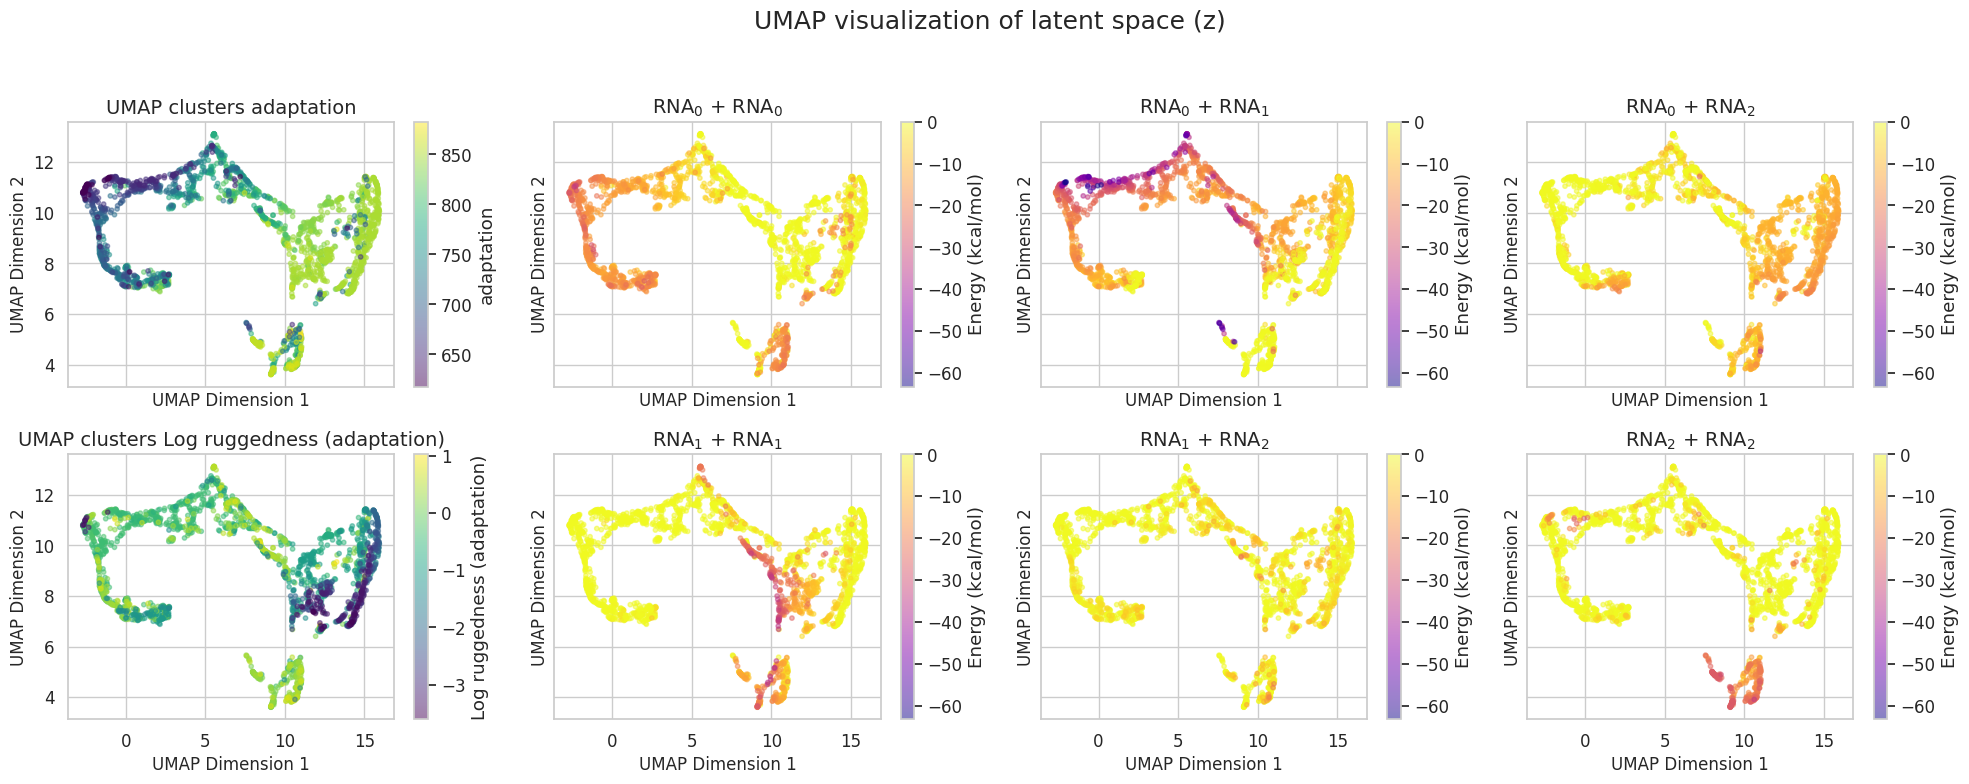

In [19]:
def visualize_dimred_2d_custom_labels(dimred_result, cond, x_bin, labels_cond, labels_x: list, method='TSNE', save_path=None, use_z=True):
    ncols = 4 if len(labels_cond) > 1 else (x_bin.shape[-1] + 1)
    nrows = len(labels_cond)
    fig, axes = plt.subplots(nrows, ncols, figsize=(
        5*ncols, 4*nrows), sharex=True, sharey=True)
    if nrows == 1:
        axes = axes[None, :]

    # Cond plots on the left
    for i, l in enumerate(labels_cond):
        ax_main = fig.add_subplot(axes[i, 0])  # Span both rows
        # idxs_hue = np.argsort(cond[:, i])[::-1]
        # idxs_hue[:len(idxs_hue)//2] = idxs_hue[:len(idxs_hue)//2][::-1]
        idxs_hue = make_sort_hue(cond[:, i], sort=True, sort_random=False, sort_flip_prop=4)
        scatter = ax_main.scatter(
            dimred_result[idxs_hue, 0], dimred_result[idxs_hue, 1], c=cond[idxs_hue, i], cmap='viridis', alpha=0.5, s=10)
        ax_main.set_title(
            f'{method} clusters {l}', fontsize=14)
        ax_main.set_xlabel(f'{method} Dimension 1', fontsize=12)
        ax_main.set_ylabel(f'{method} Dimension 2', fontsize=12)
        plt.colorbar(scatter, ax=ax_main, label=l)

    # Interaction plots on the right
    for i in range(x_bin.shape[-1]):
        row = i // (ncols-1)
        col = i % (ncols-1) + 1
        ax = fig.add_subplot(axes[row, col])
        # idxs_hue = np.argsort(x_bin[:, i])[::-1]
        # idxs_hue[:len(idxs_hue)//2] = idxs_hue[:len(idxs_hue)//2][::-1]
        idxs_hue = make_sort_hue(x_bin[:, i], sort=True, sort_random=False, sort_flip_prop=4)
        scatter = ax.scatter(
            dimred_result[idxs_hue, 0], dimred_result[idxs_hue, 1], c=x_bin[idxs_hue, i], cmap='plasma', alpha=0.5, s=10)
        ax.set_title(' + '.join(labels_x[i]), fontsize=14)
        ax.set_xlabel(f'{method} Dimension 1', fontsize=12)
        ax.set_ylabel(f'{method} Dimension 2', fontsize=12)
        scatter.set_clim(np.nanmin(x_bin), np.nanmax(x_bin))
        # if i == (x_bin.shape[-1] - 1):
        plt.colorbar(scatter, ax=ax, label=f'Energy (kcal/mol)')

    plt.suptitle(f'{method} visualization of latent space ({"z" if use_z else "h"})', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()


# cond_rev_all = np.concatenate([np.array(analytics_show[k])[
#                               :, output_idx, None] for k in labels_chosen_a], axis=-1)
visualize_dimred_2d_custom_labels(umap_result, cond_rev_all[idxs_show], all_fake_circuits_flat[idxs_show],
                                  labels_cond=labels_chosen_a,
                                  labels_x=labels_x, method=method, save_path=os.path.join(top_write_dir, 'umap.png'),
                                  use_z=use_z)

/tmp/ipykernel_2990223/3215650655.py:18: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=[0, 0, 1, 0.95])


/tmp/ipykernel_2990223/3215650655.py:18: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=[0, 0, 1, 0.95])


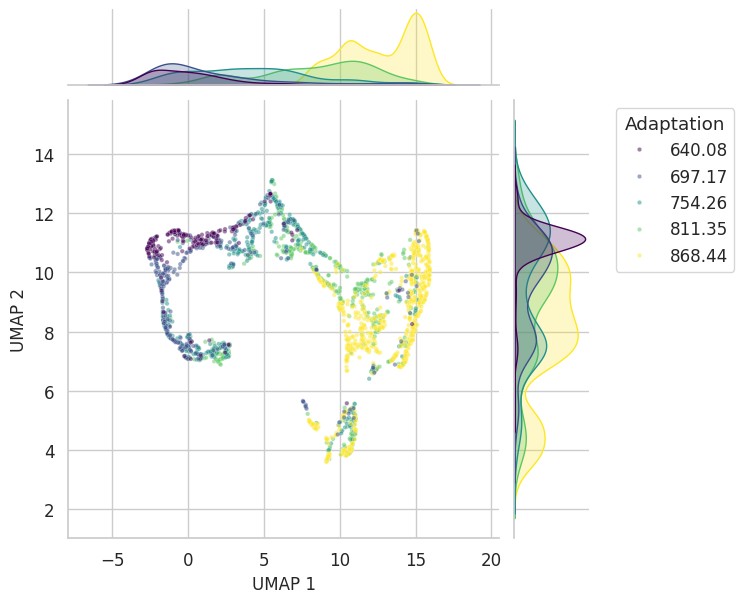

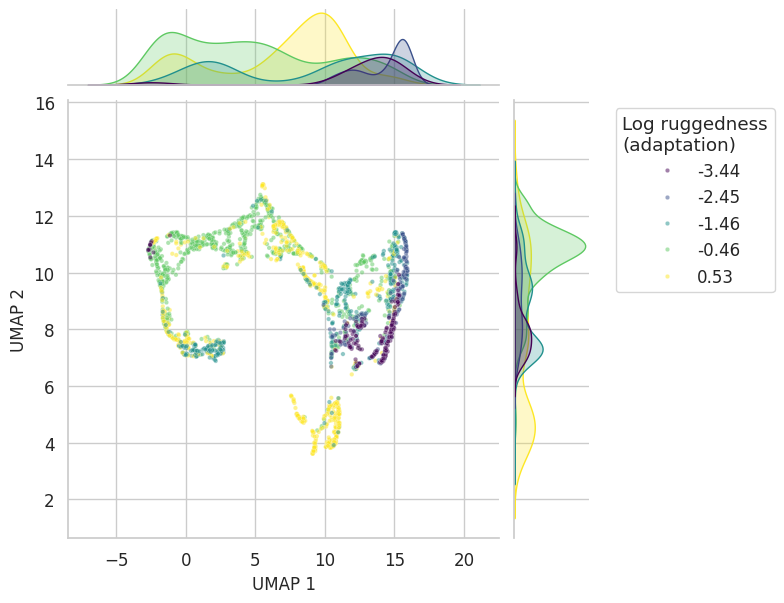

In [20]:
# cond_binned = cond_rev_all
# if not hpos.loc['prep_y_categorical']:
#     for i in range(len(config_dataset.objective_col)):
#         cond_binned[..., i] = bin_array(
#             cond_rev_all[..., i], num_bins=5)[0].round(2)
        
for i, l in enumerate(labels_chosen_a):
    # idxs_hue = np.argsort(cond_rev_all[idxs_show][:, i])[::-1]
    # idxs_hue[:len(idxs_hue)//2] = idxs_hue[:len(idxs_hue)//2][::-1]
    idxs_hue = make_sort_hue(cond_binned[idxs_show][:, i], sort=True, sort_random=False, sort_flip_prop=4)
    g = sns.jointplot(
        x=umap_result[idxs_hue, 0], y=umap_result[idxs_hue, 1], hue=cond_binned[idxs_show][idxs_hue, i], palette='viridis', alpha=0.5, s=10)
    # plt.legend(title='\n('.join(l.capitalize().split(' (')))
    sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.25, 1), title='\n('.join(l.capitalize().split(' (')))
    plt.xlabel(f'{method} 1', fontsize=12)
    plt.ylabel(f'{method} 2', fontsize=12)
    # plt.suptitle(l.capitalize(), fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(top_write_dir, f'umap_joint_{str(i)}.png'), dpi=300, bbox_inches='tight', transparent=True)

# Get motifs from UMAP

((272, 6), (100000, 6))

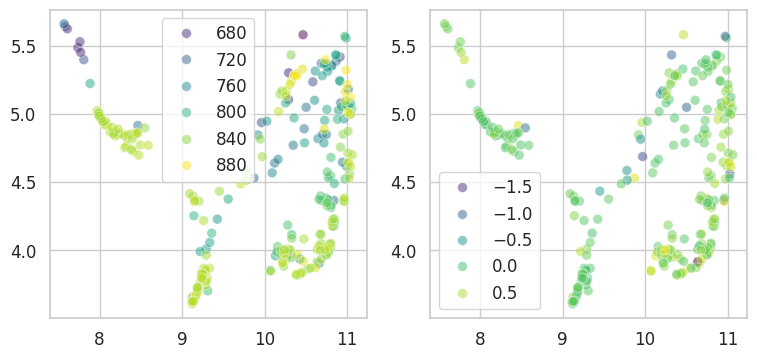

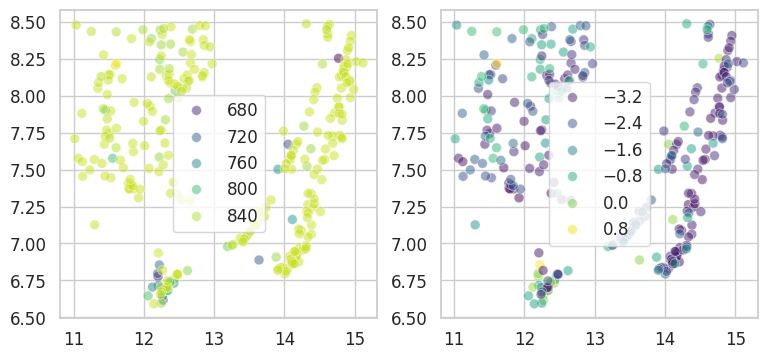

In [21]:
umap_xy_lorugg = [[11, 16], [6.5, 8.5]]
umap_xy_hirugg = [[7, 12], [3, 6]]
idxs_adaptable_lorugg = np.where((umap_result[:, 0] > umap_xy_lorugg[0][0]) & (umap_result[:, 0] < umap_xy_lorugg[0][1]) &
                         (umap_result[:, 1] > umap_xy_lorugg[1][0]) & (umap_result[:, 1] < umap_xy_lorugg[1][1]))
idxs_adaptable_hirugg = np.where((umap_result[:, 0] > umap_xy_hirugg[0][0]) & (umap_result[:, 0] < umap_xy_hirugg[0][1]) &
                         (umap_result[:, 1] > umap_xy_hirugg[1][0]) & (umap_result[:, 1] < umap_xy_hirugg[1][1]))
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
sns.scatterplot(x=umap_result[idxs_adaptable_hirugg, 0].squeeze(), y=umap_result[idxs_adaptable_hirugg, 1].squeeze(), hue=cond_rev_all[idxs_show][idxs_adaptable_hirugg, 0].squeeze(), palette='viridis', alpha=0.5, s=50, ax=axs[0])
sns.scatterplot(x=umap_result[idxs_adaptable_hirugg, 0].squeeze(), y=umap_result[idxs_adaptable_hirugg, 1].squeeze(), hue=cond_rev_all[idxs_show][idxs_adaptable_hirugg, 1].squeeze(), palette='viridis', alpha=0.5, s=50, ax=axs[1])

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
sns.scatterplot(x=umap_result[idxs_adaptable_lorugg, 0].squeeze(), y=umap_result[idxs_adaptable_lorugg, 1].squeeze(), hue=cond_rev_all[idxs_show][idxs_adaptable_lorugg, 0].squeeze(), palette='viridis', alpha=0.5, s=50, ax=axs[0])
sns.scatterplot(x=umap_result[idxs_adaptable_lorugg, 0].squeeze(), y=umap_result[idxs_adaptable_lorugg, 1].squeeze(), hue=cond_rev_all[idxs_show][idxs_adaptable_lorugg, 1].squeeze(), palette='viridis', alpha=0.5, s=50, ax=axs[1])

all_fake_circuits_flat[idxs_show][idxs_adaptable_hirugg].shape, all_fake_circuits_flat.shape

In [22]:
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols

g = sns.clustermap(all_fake_circuits_flat[idxs_show][idxs_adaptable_lorugg], col_cluster=False, row_colors=row_colors)
n_clusters = 6
row_linkage = g.dendrogram_row.linkage
clusters = fcluster(row_linkage, t=n_clusters, criterion='maxclust')

lut = dict(zip(sorted(pd.Series(clusters).unique()),
           sns.color_palette('pastel', n_clusters).as_hex()))
row_colors = pd.Series(clusters).map(lut).to_numpy()
# plt.close()
# del g

fig, ax = plt.subplots(figsize=(15, 5))
d = pd.DataFrame()
cols_e = sorted(set([hpos['x_type'] + '_' + '-'.join(sorted([str(i + 1), str(j + 1)]))
                for i, j in itertools.product(range(3), range(3))]))
d['Cluster'] = clusters
d[cols_e] = all_fake_circuits_flat[idxs_show][idxs_adaptable_lorugg]
for i, c in enumerate(labels_chosen_a):
    d[c] = cond_rev_all[idxs_show][idxs_adaptable_lorugg, i].squeeze()
pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1) - 0.2) * 1.3,
                     np.ones(n_clusters) * - 0.1]).reshape(2, -1).T
colors = sns.color_palette('pastel', n_clusters).as_hex()
d = d[d['Cluster'].apply(lambda x: np.where(clusters == x, 1, 0).sum() > 2)]
for i, c in enumerate(sorted(d['Cluster'].unique())):
    fake_circuits_cluster = d[d['Cluster']
                                    == c][cols_e].values
    w = np.median(fake_circuits_cluster, axis=0)
    create_network_inset(fig, ax,
                         pos=pos[i],
                         width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                             vmin=-30, #np.nanmin(all_fake_circuits_flat[idxs_show]), 
                                                                             vmax=0), # np.nanmax(all_fake_circuits_flat[idxs_show]),),
                                                                            #  vmin=np.nanmin(data[get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].values), 
                                                                            #  vmax=np.nanmax(data[get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].values)),
                         node_color=colors[c-1], linewidth=2.5)
ax.set_axis_off()
plt.savefig(os.path.join(top_write_dir, 'motifs_adapt_lorugg.png'), dpi=300, bbox_inches='tight', transparent=True)

NameError: name 'row_colors' is not defined

In [ ]:
d.groupby('Cluster')[labels_chosen_a].agg(['mean', 'std', 'count']).T

Cluster                                     2           3           4  \
adaptation                  mean   810.001648  782.438782  846.164001   
                            std     35.790974   54.354591    3.063039   
                            count    8.000000   23.000000    4.000000   
Log ruggedness (adaptation) mean    -1.059060   -0.393894   -0.892624   
                            std      0.092242    0.664503    0.436897   
                            count    8.000000   23.000000    4.000000   

Cluster                                     5  
adaptation                  mean   847.844971  
                            std      5.333874  
                            count  248.000000  
Log ruggedness (adaptation) mean    -2.597432  
                            std      0.893229  
                            count  248.000000

# Specific circuits

In [ ]:
# df_plot = pd.DataFrame()
# df_plot['UMAP 1'] = umap_result[:, 0]
# df_plot['UMAP 2'] = umap_result[:, 1]
# for i, l in enumerate(labels_chosen_a):
#     df_plot[l] = cond_binned[idxs_show][:, i]
    

### High adaptation, low ruggedness

In [ ]:
df_rugg['overshoot'] = analytics_og['overshoot'][..., idx_output]
df_rugg['initial_steady_states'] = analytics_og['initial_steady_states'][..., idx_output]
df_rugg['steady_states'] = analytics_og['steady_states'][..., idx_output]
df_rugg['Adaptation bin'] = pd.cut(
    df_rugg['Adaptation'], bins=10)
df_rugg['Adaptation bin'] = df_rugg['Adaptation bin'].apply(
    lambda x: x.mid).astype(float).round(2)
df_rugg.loc[np.isinf(df_rugg['Log precision']), 'Log precision'] = np.nan
df_rugg['Is adaptable'] = False
df_rugg['Is adaptable og'] = False
df_rugg.loc[(df_rugg['Log sensitivity'] > 1) & (df_rugg['Log precision'] > 0), 'Is adaptable og'] = True # np.nanmax(df_rugg['Adaptation bin']) + 20
df_rugg.loc[df_rugg['Adaptation'] > 875, 'Is adaptable og'] = True # np.nanmax(df_rugg['Adaptation bin']) + 20

# df_rugg.sort_values(by=['Adaptation bin', 'Log ruggedness (adaptation)'], ascending=False)

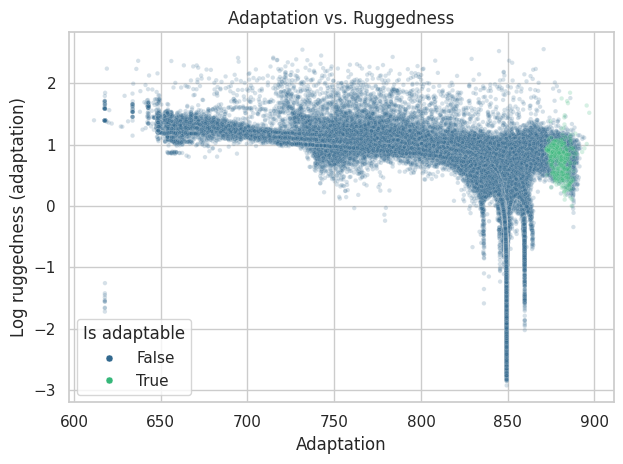

In [ ]:
hue = 'initial_steady_states'
hue = 'steady_states' 
hue = 'overshoot'
hue = 'Is adaptable'
g = sns.scatterplot(df_rugg.sort_values(by=hue), x='Adaptation', y='Log ruggedness (adaptation)',
                    hue=hue, alpha=0.2,
                    palette='viridis', s=10)

# Set legend alpha and title and size
for line in g.legend().get_lines():
    line.set(alpha=1.0, markersize=5)
g.legend_.set_title(hue)

plt.title('Adaptation vs. Ruggedness')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'adaptation_ruggedness.png'), dpi=300, bbox_inches='tight', transparent=True)

/tmp/ipykernel_973736/2537736396.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g2 = sns.violinplot(data=df_plot, x='Cluster', y='Log ruggedness (adaptation)', ax=ax3, palette='pastel')
/tmp/ipykernel_973736/2537736396.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


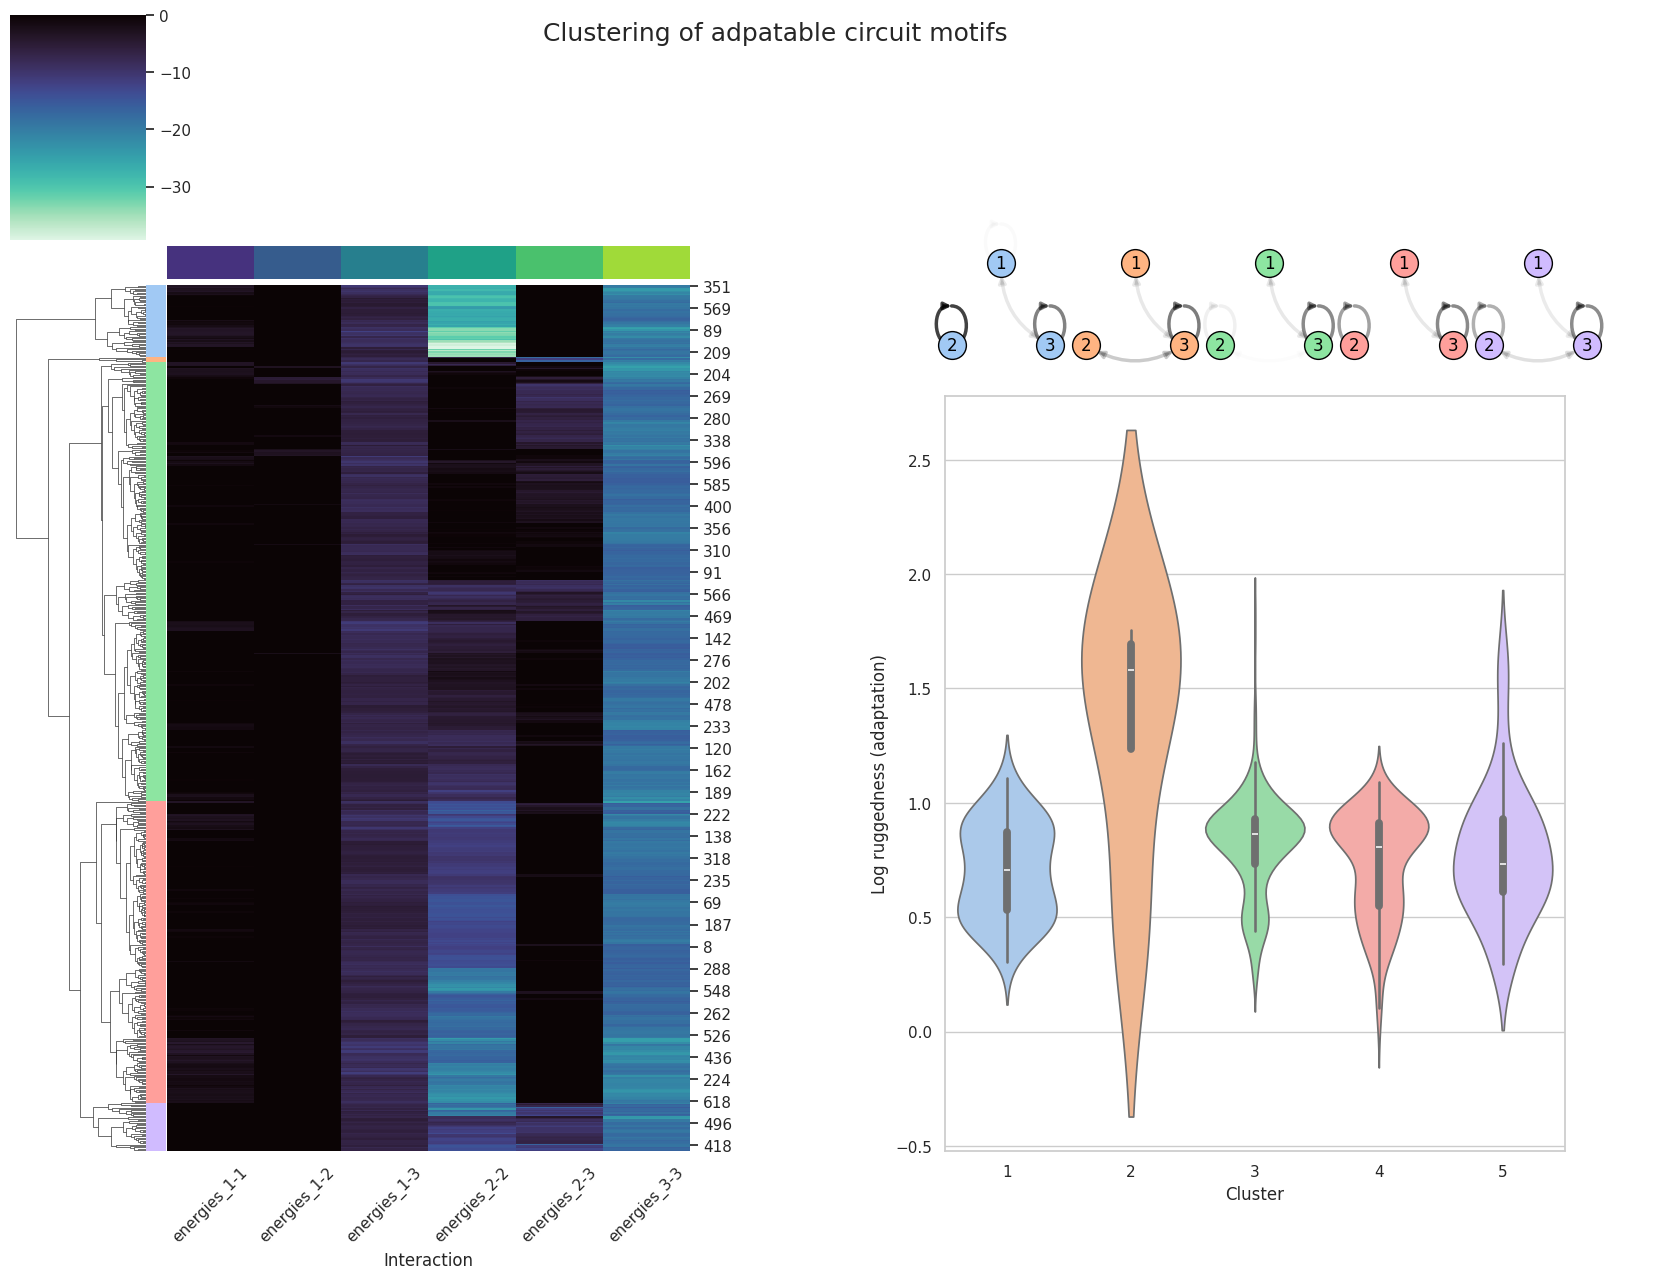

In [ ]:
idxs_adaptable = df_rugg[df_rugg['Is adaptable']].index.to_list()

n_species = 3
# cols_e = sorted(set([hpos['x_type'] + '_' + '-'.join(sorted([str(i + 1), str(j + 1)]))
#                 for i, j in itertools.product(range(3), range(3))]))
cols_e = [r'$k_{' + str(i) + str(j) + '}$' for i, j in sorted(set([tuple(sorted(i)) for i in itertools.product(np.arange(n_species) + 1, np.arange(n_species) + 1)]))]

g = sns.clustermap(all_fake_circuits_flat[idxs_adaptable], col_cluster=False)
n_clusters = 5
row_linkage = g.dendrogram_row.linkage
clusters = fcluster(row_linkage, t=n_clusters, criterion='maxclust')
df_plot = pd.DataFrame()
df_plot['Cluster'] = clusters
df_plot[cols_e] = all_fake_circuits_flat[idxs_adaptable]
df_plot['Log ruggedness (adaptation)'] = df_rugg[df_rugg['Is adaptable']]['Log ruggedness (adaptation)'].values
lut = dict(zip(sorted(df_plot['Cluster'].unique()),
           sns.color_palette('pastel', n_clusters).as_hex()))
row_colors = df_plot['Cluster'].map(lut).to_numpy()
col_colors = sns.color_palette(
    'viridis', all_fake_circuits_flat.shape[-1]).as_hex()

plt.close()
del g

figsize = (17, 12)
g = sns.clustermap(all_fake_circuits_flat[idxs_adaptable], col_cluster=False,
                   col_colors=sns.color_palette(
                       "viridis", all_fake_circuits_flat.shape[-1]),
                   row_colors=row_colors, figsize=figsize,
                   cmap='mako_r')
g.ax_heatmap.set_xlabel('Interaction')
g.ax_heatmap.set_xticklabels(cols_e, rotation=45)
g.gs.update(left=0.05, right=0.45)


gs2 = matplotlib.gridspec.GridSpec(3, 1, left=0.6)
ax2 = g.figure.add_subplot(gs2[0])
ax3 = g.figure.add_subplot(gs2[1:])

# g2 = sns.barplot(data=df_plot.melt(id_vars=['Cluster'],
#                                    value_vars=cols_e,
#                                    value_name='Energy (kcal/mol)',
#                                    var_name='Interaction').sort_values('Interaction'),
#                  x='Cluster', y='Energy (kcal/mol)', hue='Interaction',
#                  ax=ax3, palette='viridis')
g2 = sns.violinplot(data=df_plot, x='Cluster', y='Log ruggedness (adaptation)', ax=ax3, palette='pastel')
# sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))

# ax2.set_title('Interactions per cluster')
ax2.set_axis_off()
pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1) - 0.2) * 1.3,
                     np.ones(n_clusters) * - 0.1]).reshape(2, -1).T
colors = sns.color_palette('pastel', n_clusters).as_hex()
for i, c in enumerate(sorted(df_plot['Cluster'].unique())):
    fake_circuits_cluster = df_plot[df_plot['Cluster']
                                    == c][cols_e].values
    w = np.median(fake_circuits_cluster, axis=0)
    create_network_inset(fig, ax2,
                         pos=pos[i],
                         width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                             vmin=np.min(df_plot[cols_e]), vmax=np.max(df_plot[cols_e])),
                         node_color=colors[i], linewidth=2.5)

plt.suptitle('Clustering of adpatable circuit motifs', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(
    top_write_dir, 'interaction_energy_clusters.png'), dpi=300, transparent=True)

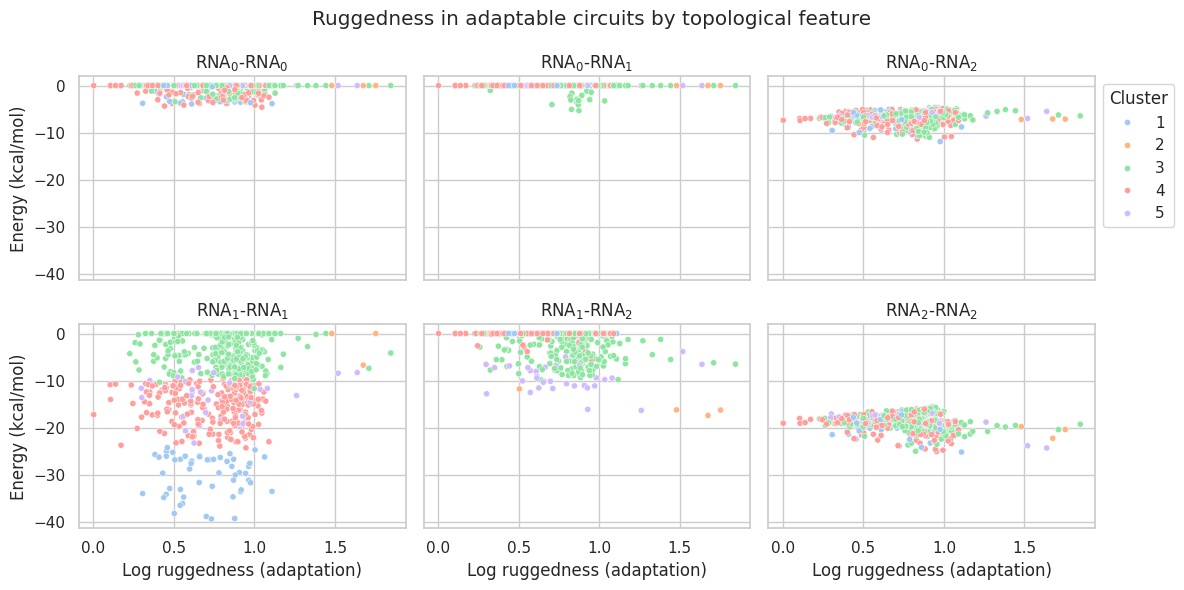

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(4*3, 3*2), sharex=True, sharey=True)
for i, c in enumerate(cols_e):
    # sns.scatterplot(df_plot.melt(id_vars=['Log ruggedness (adaptation)'],
    #                          value_vars=cols_e, value_name='Energy (kcal/mol)', var_name='Interaction'),
    is_legend = True if i == 2 else False
    g = sns.scatterplot(df_plot,
                    x='Log ruggedness (adaptation)', y=c, hue='Cluster', alpha=1, s=20,
                    ax=axs.flat[i], palette='pastel', legend=is_legend)
    axs.flat[i].set_ylabel('Energy (kcal/mol)')
    axs.flat[i].set_title('-'.join(labels_x[i]))
    if is_legend:
        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.suptitle('Ruggedness in adaptable circuits by topological feature')
plt.tight_layout()
plt.savefig(os.path.join(
    top_write_dir, 'ruggedness_by_interaction_energy.png'), dpi=300, transparent=True)

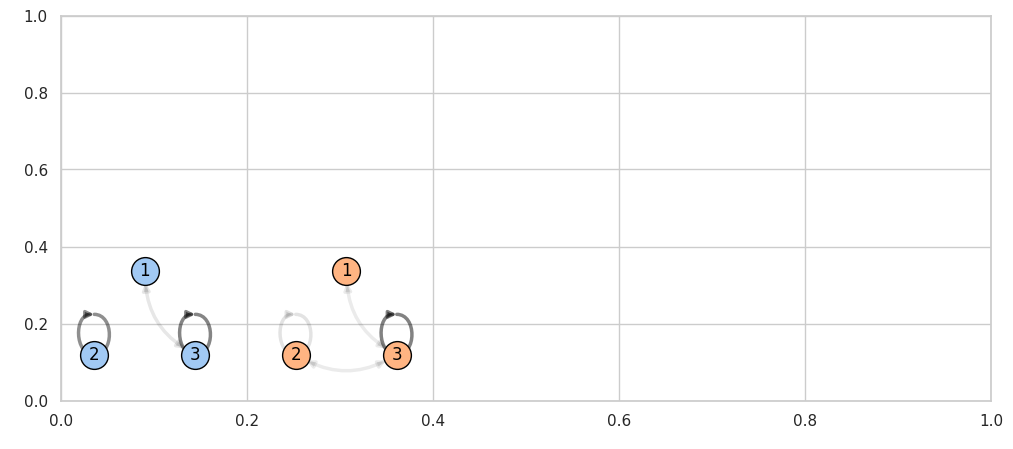

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
i_lowest = df_plot['Log ruggedness (adaptation)'].idxmin()
i_highest = df_plot['Log ruggedness (adaptation)'].idxmax()
for i, idx in enumerate([i_lowest, i_highest]):
    w = df_plot.iloc[idx][cols_e].values
    # w = np.median(fake_circuits_cluster, axis=0)
    create_network_inset(fig, ax,
                         pos=pos[i],
                         width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                             vmin=np.min(df_plot[cols_e]), vmax=np.max(df_plot[cols_e])),
                         node_color=colors[i], linewidth=2.5)
ax.set_axis_off()